<a href="https://colab.research.google.com/github/Bayesian-Logic/waveforms/blob/main/notebooks/segment_trainer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook trains a Deep Learning model to learn the arrival time of waveforms.

In [9]:
# @title Default title text
EXPERIMENT = "exp001" # @param {type:"string"}
NOTES = "first run" # @param {type:"string"}
DEBUG_RUN = False # @param {type:"boolean"}
DISABLE_WANDB = True # @param {type:"boolean"}
# @markdown Checking TRAIN_FULL will result in a model that trains on the entire dataset.
# @markdown Only do this for final testing.
TRAIN_FULL = False # @param {type:"boolean"}
TRAIN_FILE = "2022001-2022010.db" # @param ["2022001-2022010.db"] {allow-input: true}

DATA_DIR = "/content/data"
OUTPUT_DIR="/content/output"
import os
os.makedirs(OUTPUT_DIR, exist_ok=True)


In [16]:
# @title CONFIG OPTIONS
import yaml, os

CONFIG = yaml.safe_load(f"""
exp_name: {EXPERIMENT}
notes: {NOTES}
disable_wandb: {DISABLE_WANDB}
output_dir: {OUTPUT_DIR}
data_dir: {DATA_DIR}

model:
  pos_weight: 1
  class: UNetTransformer
  UNetTransformer:
    feedforward_mult: 3
    d_model: 256
    n_heads: 8,
    kernel_size: 17
    n_layers: 6
    dropout_prob: 0.1

train:
  fold_idx: 0
  num_folds: 4
  data_window: 100 # LEB arrivals are centered in the data_window in each datum
  train_window: 60 # a random subset of size train_window is selected from each datum
  batch_size: 32
  seed: 42
  epoch: 10
  num_workers: 2
  accelerator: auto
  use_amp: true
  debug: {DEBUG_RUN}
  gradient_clip_val: 1.0
  accumulate_grad_batches: 1
  check_val_every_n_epoch: 1
  train_full: {TRAIN_FULL}
  deterministic: true
  train_file: {TRAIN_FILE}

optimizer:
  lr: 0.0005
  class: AdamW  # SGD or AdamW
  SGD:
    momentum: 0.9
    weight_decay: 0
    nesterov: false
    dampening: 0
  AdamW:
    weight_decay: 0
  scheduler: cosine
  num_warmup_steps: 0
""")

# Setup

In [3]:
# @title Create a logger for Colab.
import logging
from datetime import datetime

# Create a root logger with the level set to INFO
logger = logging.getLogger()
logger.setLevel(logging.INFO)

# Remove all existing handlers
for handler in logger.handlers[:]:  # Iterate over a copy of the list to avoid modification during iteration
    handler.close()
    logger.removeHandler(handler)


# Create a formatter with timestamp
formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(name)s - %(message)s', datefmt='%Y-%m-%d %H:%M:%S')

# Create a custom handler to capture logs and display them in the output cell
class ColabHandler(logging.Handler):
    def emit(self, record):
        log_entry = self.format(record)
        print(log_entry)

# Add the custom handler to the logger
ch = ColabHandler()
ch.setFormatter(formatter)
logger.addHandler(ch)

info = logging.getLogger().info

info("Logger created.")

2024-01-17 01:17:57 - INFO - root - Logger created.


In [4]:
# @title Clone the github repository
from google.colab import userdata
GITHUB_TOKEN = userdata.get('GITHUB_WAVEFORMS_TOKEN')
REPO = "waveforms"
REPO_URL = f"https://{GITHUB_TOKEN}@github.com/Bayesian-Logic/{REPO}.git"
import os
if not os.path.exists(REPO):
  info("Cloning github repository.")
  !git clone $REPO_URL
  # configuring user name and email to allow us to make changes
  !git config  --global user.email "nimar.arora@gmail.com"
  !git config  --global user.name "Nimar Arora"
  !git config  --global pull.rebase true
else:
  info("Github repository already exists.")
import sys
repo_path = f"/content/{REPO}/src"
if sys.path[1] != repo_path:
  sys.path.insert(1, repo_path)
# it's handy to use the autoreload extension in case we need to change some code
# but if not changing code then you could remove these two lines.
%load_ext autoreload
%autoreload 2


2024-01-17 01:17:58 - INFO - root - Github repository already exists.


In [5]:
# @title Download data
import os
import json
import concurrent.futures
from google.colab import userdata
from google.oauth2 import service_account
from google.cloud import storage

# Set up data directory
os.environ['DATA_DIR'] = '/content/data'

def download_file(filename):
    account_info = json.loads(userdata.get('GCP_SERVICE_ACCOUNT'))
    credentials = service_account.Credentials.from_service_account_info(account_info)
    storage_client = storage.Client(credentials=credentials)

    bucket = storage_client.bucket('segment-waveforms')
    blob = bucket.blob(filename)
    blob.download_to_filename(os.path.join(DATA_DIR, filename))

if not os.path.exists(DATA_DIR):
    info("Downloading data.")
    !mkdir -p $DATA_DIR

    download_file(TRAIN_FILE)

    info("Finished downloading data.")

else:
    info("Data already downloaded.")

2024-01-17 01:17:59 - INFO - root - Data already downloaded.


In [6]:
# @title Login to wandb
!pip -q install wandb
from google.colab import userdata
import os
os.environ["WANDB_API_KEY"] = userdata.get('WANDB_API_KEY')
os.environ["WANDB_ENTITY"] = userdata.get("WANDB_ENTITY")
os.environ["WANDB_PROJECT"] = "segment-waveforms"
import wandb
wandb.login()

wandb: Currently logged in as: nimar-arora. Use `wandb login --relogin` to force relogin


True

In [7]:
# @title Install some needed external packages
!pip -q install torchinfo pytorch_lightning transformers
import torch, torchinfo, pytorch_lightning, transformers
info("torch: %s" % torch.__version__)
info("torchinfo: %s" % torchinfo.__version__)
info("pytorch_lightning: %s" % pytorch_lightning.__version__)
info("transformers: %s" % transformers.__version__)

2024-01-17 01:18:24 - INFO - root - torch: 2.1.0+cu121
2024-01-17 01:18:24 - INFO - root - torchinfo: 1.8.0
2024-01-17 01:18:24 - INFO - root - pytorch_lightning: 2.1.3
2024-01-17 01:18:24 - INFO - root - transformers: 4.35.2


# Train a model

In [8]:
from seg.utils.train import do_train
model = do_train(CONFIG)

2024-01-17 01:18:24 - INFO - lightning_fabric.utilities.seed - Seed set to 42


In [18]:
from seg.data.datamodule import SegDataModule
import json
from types import SimpleNamespace
cfg = json.loads(json.dumps(CONFIG), object_hook=lambda d: SimpleNamespace(**d))
data = SegDataModule(cfg)
data.prepare_data()

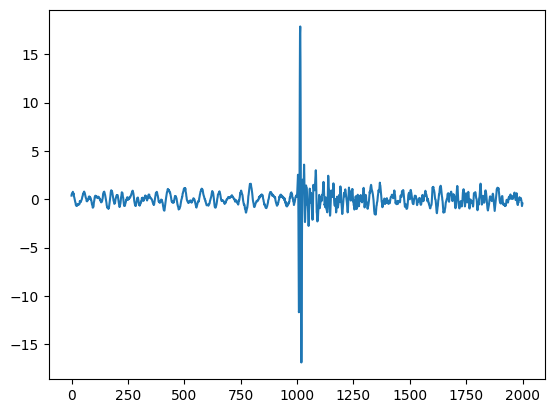

In [20]:
import numpy as np
import matplotlib.pyplot as plt

data = np.load("/content/data/prepared/21593864_166653583.npy")
plt.plot(data)

In [21]:
len(data)

2000